# Generate propagation raw sequences from songs graphs with and without time metadata  (with date order)

In [172]:
#!pip install subseq

### Import required libraries

In [173]:
import pandas as pd
import os
import numpy as np

from tqdm.notebook import tqdm
import json
import networkx as nx

import matplotlib.pyplot as plt

import math

from subseq.subseq import Subseq

### Load datasets

Dataset generated in notebook 02b

In [174]:
source= 'spotify'
ranking_df= pd.read_csv(os.path.join('data', 'clean_ranking_2017_2022_v2.csv'), index_col=0, parse_dates=['Date', 'release_date'])

if source== 'lfm':
    ranking_df= pd.read_csv(os.path.join('data', 'LMF-2b', 'clean_ranking_2005_2020_lfm.csv'), index_col=0, parse_dates=['Date', 'release_date'])
    
ranking_df.head()

#ranking_df= pd.read_csv(os.path.join('data', 'clean_ranking_2017_2021_v2.csv'), index_col=0, parse_dates=['Date', 'release_date'])
#ranking_df.head()

/home/fterroso/.local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Position,Track Name,Artist,Streams,Date,Region,song_id,release_date,day_of_study,release_month
16,17,Olha a Explosão,MC Kevinho,12388,2018-01-01,Ecuador,6m2LNopVJKsvBB9l7Z1rwn,2017-01-01,365,1
19,20,Besame,"Valentino, Manuel Turizo",11127,2018-01-01,Ecuador,7Ckhk1XW5NV2k4jpqtQNlz,2017-06-03,365,6
22,23,Una Lady Como Tú,Manuel Turizo,10766,2018-01-01,Ecuador,7MHN1aCFtLXjownGhvEQlF,2017-04-12,365,4
25,26,Scooby Doo Pa Pa,Dj Kass,9879,2018-01-01,Ecuador,1xndOD8CreR5ctkOv5G1LN,2017-12-08,365,12
28,29,Déjate Llevar,"Juan Magán, Belinda, Manuel Turizo, Snova, B-Case",8995,2018-01-01,Ecuador,3xWEI23MLJrD0dpDcDUTW6,2017-11-28,365,11


In [175]:
ranking_df['week_of_study']= ranking_df['day_of_study'].apply(lambda x : int(x/7))

In [176]:
ranking_df = ranking_df[ranking_df['Region']!='World']

In [177]:
ranking_df['Region'].unique()

array(['Ecuador', 'Portugal', 'Panama', 'Italy', 'Germany', 'Finland',
       'Estonia', 'Hungary', 'Spain', 'Peru', 'Slovakia', 'Ireland',
       'Indonesia', 'Iceland', 'Brazil', 'Canada', 'Belgium', 'Uruguay',
       'CostaRica', 'Malaysia', 'Mexico', 'France', 'Argentina', 'Norway',
       'Lithuania', 'Philippines', 'Taiwan', 'NewZealand', 'Turkey',
       'USA', 'ElSalvador', 'Chile', 'Japan', 'Honduras', 'Guatemala',
       'Switzerland', 'Denmark', 'Bolivia', 'Poland', 'Austria', 'Sweden',
       'CzechRepublic', 'Netherlands', 'Columbia', 'Singapore',
       'DominicanRepublic', 'Luxemborg', 'UnitedKingdom', 'Paraguay',
       'Australia', 'Latvia', 'Greece', 'HongKong', 'Russia',
       'UnitedArabEmirates', 'Belarus', 'India', 'SouthAfrica', 'Romania',
       'Ukraine', 'Egypt', 'Nigeria', 'Korea', 'Kazakhstan',
       'SaudiArabia', 'Nicaragua', 'Marocco', 'Israel', 'Bulgaria',
       'Vietnam'], dtype=object)

In [178]:
codes_to_country = {'ar':'Argentina', 'at':'Austria', 'au':'Australia', 'be':'Belgium','bl':'Belarus', 'bu':'Bulgaria',
       'bo':'Bolivia', 'br':'Brazil', 'ca':'Canada', 'ch':'Switzerland', 
       'cl':'Chile', 'co':'Columbia', 'cr':'CostaRica', 'cz':'CzechRepublic',
       'de':'Germany', 'dk':'Denmark', 'do':'DominicanRepublic', 'ec':'Ecuador', 
       'ee':'Estonia', 'es':'Spain', 'eg': 'Egypt', 'fi':'Finland', 'fr':'France', 
       'gb':'UnitedKingdom', 'global':'World', 'gr':'Greece', 'gt':'Guatemala',
       'hk':'HongKong', 'hn':'Honduras', 'hu':'Hungary', 'id':'Indonesia', 
       'ie':'Ireland', 'in': 'India', 'is':'Iceland', 'ir': 'Israel', 'it':'Italy', 'jp':'Japan', 
       'lt':'Lithuania', 'lu':'Luxemborg', 'lv':'Latvia', 'ma':'Marocco', 'mx':'Mexico', 
       'my':'Malaysia', 'ni': 'Nicaragua', 'ng': 'Nigeria', 'nl':'Netherlands', 'no':'Norway', 'nz':'NewZealand', 
       'pa':'Panama', 'pe':'Peru', 'ph':'Philippines', 'pl':'Poland', 
       'pt':'Portugal', 'py':'Paraguay', 'kz': 'Kazakhstan', 'se':'Sweden', 'sg':'Singapore', 
       'sk':'Slovakia', 'sv':'ElSalvador', 'tr':'Turkey', 'tw':'Taiwan', 'ua': 'UnitedArabEmirates', 'uk':'Ukraine', 'us':'USA', 'uy':'Uruguay',
        'ro':'Romania', 'ru': 'Russia', 'sa': 'SouthAfrica', 'sd': 'SaudiArabia', 'ko':'Korea', 'vt': 'Vietnam' } 

In [179]:
country_to_code = {v: k for k, v in codes_to_country.items()}
country_to_code

{'Argentina': 'ar',
 'Austria': 'at',
 'Australia': 'au',
 'Belgium': 'be',
 'Belarus': 'bl',
 'Bulgaria': 'bu',
 'Bolivia': 'bo',
 'Brazil': 'br',
 'Canada': 'ca',
 'Switzerland': 'ch',
 'Chile': 'cl',
 'Columbia': 'co',
 'CostaRica': 'cr',
 'CzechRepublic': 'cz',
 'Germany': 'de',
 'Denmark': 'dk',
 'DominicanRepublic': 'do',
 'Ecuador': 'ec',
 'Estonia': 'ee',
 'Spain': 'es',
 'Egypt': 'eg',
 'Finland': 'fi',
 'France': 'fr',
 'UnitedKingdom': 'gb',
 'World': 'global',
 'Greece': 'gr',
 'Guatemala': 'gt',
 'HongKong': 'hk',
 'Honduras': 'hn',
 'Hungary': 'hu',
 'Indonesia': 'id',
 'Ireland': 'ie',
 'India': 'in',
 'Iceland': 'is',
 'Israel': 'ir',
 'Italy': 'it',
 'Japan': 'jp',
 'Lithuania': 'lt',
 'Luxemborg': 'lu',
 'Latvia': 'lv',
 'Marocco': 'ma',
 'Mexico': 'mx',
 'Malaysia': 'my',
 'Nicaragua': 'ni',
 'Nigeria': 'ng',
 'Netherlands': 'nl',
 'Norway': 'no',
 'NewZealand': 'nz',
 'Panama': 'pa',
 'Peru': 'pe',
 'Philippines': 'ph',
 'Poland': 'pl',
 'Portugal': 'pt',
 'Paraguay

We are going to use the country codes for the sequences generation instead the verbose ones

In [180]:
ranking_df['Region_code'] = ranking_df['Region'].apply(lambda r: country_to_code[r])

In [181]:
ranking_df[ranking_df['song_id']=='4nK5YrxbMGZstTLbvj6Gxw']

,Position,Track Name,Artist,Streams,Date,Region,song_id,release_date,day_of_study,release_month,week_of_study,Region_code
161779,180,Supalonely,"BENEE, Gus Dapperton",3961,2020-03-19,Ecuador,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1173,11,167,ec
162569,170,Supalonely,"BENEE, Gus Dapperton",4057,2020-03-23,Ecuador,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1177,11,168,ec
162756,157,Supalonely,"BENEE, Gus Dapperton",4163,2020-03-24,Ecuador,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1178,11,168,ec
162945,146,Supalonely,"BENEE, Gus Dapperton",4365,2020-03-25,Ecuador,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1179,11,168,ec
163136,137,Supalonely,"BENEE, Gus Dapperton",4641,2020-03-26,Ecuador,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1180,11,168,ec
...,...,...,...,...,...,...,...,...,...,...,...,...
21180147,176,Supalonely,"BENEE, Gus Dapperton",2982,2020-07-19,Vietnam,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1295,11,185,vt
21180355,184,Supalonely,"BENEE, Gus Dapperton",2966,2020-07-20,Vietnam,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1296,11,185,vt
21180547,176,Supalonely,"BENEE, Gus Dapperton",3182,2020-07-21,Vietnam,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1297,11,185,vt
21180763,192,Supalonely,"BENEE, Gus Dapperton",3033,2020-07-22,Vietnam,4nK5YrxbMGZstTLbvj6Gxw,2019-11-15,1298,11,185,vt


In [182]:
ranking_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2749683 entries, 16 to 22869852
Data columns (total 12 columns):
 #   Column         Dtype         
---  ------         -----         
 0   Position       int64         
 1   Track Name     object        
 2   Artist         object        
 3   Streams        int64         
 4   Date           datetime64[ns]
 5   Region         object        
 6   song_id        object        
 7   release_date   datetime64[ns]
 8   day_of_study   int64         
 9   release_month  int64         
 10  week_of_study  int64         
 11  Region_code    object        
dtypes: datetime64[ns](2), int64(5), object(5)
memory usage: 272.7+ MB


In [183]:
total_songs = ranking_df['song_id'].nunique()
print(f'The number of total songs is {total_songs}')

The number of total songs is 8467


### Read songs genres

In [184]:
song_genres_df = pd.read_csv(os.path.join('data', 'songs_genres_2017_2022.csv'), index_col=0)
song_genres_df.head()

,0,1,2,3,4,5,6
6m2LNopVJKsvBB9l7Z1rwn,funk,pop,NaN,NaN,NaN,NaN,NaN
7Ckhk1XW5NV2k4jpqtQNlz,reggaeton,latin,NaN,NaN,NaN,NaN,NaN
7MHN1aCFtLXjownGhvEQlF,reggaeton,latin,NaN,NaN,NaN,NaN,NaN
1xndOD8CreR5ctkOv5G1LN,hardcore,NaN,NaN,NaN,NaN,NaN,NaN
3xWEI23MLJrD0dpDcDUTW6,reggaeton,latin,pop,NaN,NaN,NaN,NaN


In [185]:
### Read songs genre groups

import json

# Opening JSON file
f = open(os.path.join('data','music_styles_unique.json'))
 
# returns JSON object as a dictionary
music_styles = json.load(f)

sub_gender_to_gender = {}
for gender, sub_genders in music_styles.items():
    for sb in sub_genders:
        sub_gender_to_gender[sb]=gender
sub_gender_to_gender

{'pop rock': 'pop',
 'pop': 'pop',
 'british': 'pop',
 'j-pop': 'pop',
 'k-pop': 'pop',
 'mandopop': 'pop',
 'cantopop': 'pop',
 'hip-hop': 'hip-hop',
 'funk': 'hip-hop',
 'trap': 'hip-hop',
 'rap': 'hip-hop',
 'rock': 'rock',
 'rockabilly': 'rock',
 'metal': 'rock',
 'punk': 'rock',
 'metalcore': 'rock',
 'hardcore': 'rock',
 'j-rock': 'rock',
 'grunge': 'rock',
 'trance': 'electronic',
 'chill': 'electronic',
 'dance': 'electronic',
 'edm': 'electronic',
 'house': 'electronic',
 'dubstep': 'electronic',
 'dancehall': 'electronic',
 'electro': 'electronic',
 'techno': 'electronic',
 'electronic': 'electronic',
 'club': 'electronic',
 'latin': 'latin',
 'reggaeton': 'latin',
 'spanish': 'latin',
 'pagode': 'latin',
 'cumbia': 'latin',
 'salsa': 'latin',
 'latino': 'latin',
 'sertanejo': 'latin',
 'mpb': 'latin',
 'anime': 'indie',
 'indie': 'indie',
 'alternative': 'indie',
 'emo': 'indie',
 'soundtracks': 'classical and ost',
 'classical': 'classical and ost',
 'piano': 'classical and

In [186]:
music_styles.keys()

dict_keys(['pop', 'hip-hop', 'rock', 'electronic', 'latin', 'indie', 'classical and ost', 'folk/traditional', 'rythm and blues', 'miscellaneous'])

### Auxiliary functions

In [187]:
from datetime import date, timedelta

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

In [188]:
def get_paths_from_graph(df, cutoff_=5):
    
    G = nx.from_pandas_edgelist(df, 'source', 'target', ['weight'], create_using=nx.DiGraph())

    roots = []
    leaves = []
    for node in G.nodes:
        if G.in_degree(node) == 0 : # it's a root
            roots.append(node)
        elif G.out_degree(node) == 0 : # it's a leaf
                leaves.append(node)
    
    paths = []
    for root in roots :
        for leaf in leaves :
            for path in nx.all_simple_paths(G, root, leaf, cutoff= cutoff_):
                paths.append(path)

    return paths

### Generate sequences from graph

In [189]:
def compute_weight_fn(target_country, song_ranking_, init_day, d_curr, week_diff, weight_coeff_):
    
    country_values = []
    #weights = []  
    for d_target in daterange(init_day, d_curr+timedelta(1)):
        rank =song_ranking_[(song_ranking_['Region_code']==target_country) & 
                                    (song_ranking_['Date']==d_target)]['Position']
        if not rank.empty:
            rank_value = rank.values[0]

            diff_ = (d_target-d_curr).days
            weight = math.exp((diff_/weight_coeff_))

            value_ = weight * (float(rank_value)**-1)
            country_values.append(value_)
                
    link_value = ((float(week_diff)**-1) * sum(country_values))
        
    return link_value

def compute_ranking_weight_fn(target_country, song_ranking_, init_day, d_curr):
    country_values = []
    rank_lst = []  
    for d_target in daterange(init_day, d_curr+timedelta(1)):
        rank =song_ranking_[(song_ranking_['Region_code']==target_country) & 
                                    (song_ranking_['Date']==d_target)]['Position']
        if not rank.empty:
            rank_value = rank.values[0]
            rank_lst.append(rank_value)
            
    rank_series = pd.Series(rank_lst)
    return rank_series.ewm(alpha=0.1, adjust=False).mean().mean()

In [190]:
def generate_sequences_fn(min_link_val, n_day_lags_):
    
    all_paths= []
    all_paths_dates_= {}
    weight_coeff_= int(n_day_lags_/2)

    for s in tqdm(ranking_df['song_id'].unique()):
         #print('-------------',s)

        country_songs = set()
        all_countries = set()
        prev_origins = set()

        song_ranking= ranking_df[ranking_df['song_id']==s]
        dates=song_ranking.groupby('Region_code')['Date'].min().to_frame()
        dates_sort=dates.sort_values('Date')
        dates_sort= dates_sort.reset_index().set_index('Date')

        dates_lst=dates_sort.index.unique()

        src_lst = []
        target_lst = []
        weight_lst = []

        num_countries_at_d = -1

        for d in dates_lst:

            countries_at_d = set(song_ranking[song_ranking['Date']==d]['Region_code'].unique())

            num_countries_at_d = len(countries_at_d)

            # We only use as origins countries that have not act as origin so far.
            o_countries = list((country_songs.intersection(countries_at_d))-prev_origins)
            d_countries = countries_at_d-country_songs

            #print(f'date: {d.strftime("%d-%m-%Y")}')

            link_values =[]
            for oc in o_countries:
                init_week = song_ranking[song_ranking['Region_code']==oc]['week_of_study'].min()
                init_date = song_ranking[song_ranking['Region_code']==oc]['Date'].min()

                curr_week = song_ranking[(song_ranking['Region_code']==oc) & 
                                         (song_ranking['Date']==d)]['week_of_study'].values[0]

                week_diff = (curr_week-init_week)+1

                init_day = d - timedelta(n_day_lags_)

                days_diff = (d-init_date).days
                if  days_diff < n_day_lags_:
                    init_day = d - timedelta(days_diff)

                #link_value = compute_ranking_weight_fn(oc, song_ranking, init_day, d)
                
                link_value= compute_weight_fn(oc, 
                                               song_ranking, 
                                               init_day, 
                                               d, 
                                               week_diff, 
                                               weight_coeff_)
                
                if link_value >= min_link_val:
                    for dc in d_countries:
                        if dc not in all_countries:
                            src_lst.append(oc)
                            target_lst.append(dc)
                            weight_lst.append(link_value)


            country_songs = countries_at_d
            all_countries = all_countries.union(countries_at_d)
            prev_origins = prev_origins.union(o_countries)

            graph_df= pd.DataFrame({"source": src_lst, "target": target_lst, 'weight': weight_lst}) 
            #if not graph_df.empty:
            #    print(graph_df)
            song_paths =  get_paths_from_graph(graph_df, cutoff_=5)
            
 
            if len(song_paths)>0:
                song_path_lst = []
                for p in song_paths:
                    song_path_lst.append(p)

                date_paths = all_paths_dates_.get(d,{})
                date_paths[s] = song_path_lst
                all_paths_dates_[d] = date_paths

        graph_df= pd.DataFrame({"source": src_lst, "target": target_lst, 'weight': weight_lst})

        song_paths =  get_paths_from_graph(graph_df, cutoff_=5)
        for p in song_paths:
            all_paths.append(p)
        #print(all_paths)
    return all_paths_dates_, all_paths

In [191]:
n_day_lags = 14

# Variables to store the results
acc_results = {}
top_acc_results = {}
all_dates_acc_results = {}
database_size_evol = {}
genres_acc_results = {}

for threshold_ in [0.16]:#tqdm(np.arange(0.01, 0.16, 0.01)):
#for threshold_ in tqdm([10, 50, 100, 150]):

    #1. Generate the sequences
    print('------------')
    print(f'Weight threshold: {threshold_}')
    all_paths_dates, all_paths = generate_sequences_fn(threshold_, n_day_lags)

    target_days = list(all_paths_dates.keys())
    target_days.sort()

    total_seqs = 0
    considered_songs = []
    for d in target_days:
        d_paths = all_paths_dates[d]
        for s in d_paths.keys():
            total_seqs += len(d_paths[s])
            considered_songs.append(s)
    print(f'The total number of extracted sequences is : {total_seqs}')
    print(f'The total number of songs is : {len(set(considered_songs))} '\
          f'({round(len(set(considered_songs))/total_songs,3)})')
    print(f'The total number of dates is : {len(target_days)}')

    # 2. Split in train-test datasets
    training_rate = 0.8
    num_train_seqs = int(total_seqs*training_rate)

    accumulated_count = 0
    training_date = None
    for d in target_days:
        d_paths = all_paths_dates[d]
        for s in d_paths.keys():
            accumulated_count += len(d_paths[s])

        #print(d, accumulated_count)
        if accumulated_count >= num_train_seqs:
            training_date = d
            break

    print(f'The cutoff date for training is {training_date}')
   
    training_seqs= []
    for d in target_days:
        #print(d)
        d_paths = all_paths_dates[d]
        for s in d_paths.keys():
            if d <= training_date:
                training_seqs += d_paths[s]

    ### 3. Train the model

    print(f'The number of training sequences is {len(training_seqs)}')
    #print(f'The number of test sequences is {len(test_seqs)}')

    model = Subseq(0)
    model.fit(training_seqs)

    ### 4. Test the model

    forecast_horizon = 1
    acc ={}
    top_acc = {}
    for date in tqdm(daterange(training_date, target_days[-1]), leave=False, desc='Test dates'):
        if date in all_paths_dates:
            date_seqs = []
            date_acc_results = []
            for song_id, songs_seq in tqdm(all_paths_dates[date].items(), 
                                           leave=False, desc=f'Songs for date {date}'):
                y= []
                y_hat=[]
                #print(date, song_id, len(songs_seq))
                for p in songs_seq:
                    #print('-->', p)
                    lag_seq= p[:-forecast_horizon]
                    true_y= p[-forecast_horizon:]

                    pred_y = model.predict_k(lag_seq, k=forecast_horizon)
                    y += true_y
                    y_hat +=pred_y
                
                #print(y)
                y=set(y)
                y_hat= set(y_hat)
                #print(y)
                
                pred_overlap = y.intersection(y_hat)
                pred_rate = len(pred_overlap)/len(y)
                
                acc_k = acc.get(len(y),[])
                acc_k.append(pred_rate)
                acc[len(y)]=acc_k
                
                #if the target sequence only comprises one country as ouput...
                if len(y)== 1:
                    #...update the time-based accuracy results and...
                    date_acc_results.append(pred_rate)
                    #...the genre-based accuracy results (if the song has a list of genres)
                    if song_id in song_genres_df.index:
                        genres_ = song_genres_df.loc[song_id].values
                        for g in genres_:
                            if (g is not np.nan) and (g in sub_gender_to_gender):
                                acc_t = genres_acc_results.get(threshold_,{})
                                acc_g = acc_t.get(sub_gender_to_gender[g],[])
                                acc_g.append(pred_rate)                                
                                acc_t[sub_gender_to_gender[g]]=acc_g
                                genres_acc_results[threshold_]= acc_t
                
                l1_top_acc_dict= top_acc.get(len(y_hat),{})
                
                for i in range(1,len(y_hat)+1):
                    l2_top_acc = l1_top_acc_dict.get(i,[])
                    if i <= len(pred_overlap):
                        l2_top_acc.append(1)
                    else:
                        l2_top_acc.append(0)
                        
                    l1_top_acc_dict[i]= l2_top_acc
                top_acc[len(y_hat)]= l1_top_acc_dict
            
                date_seqs += songs_seq
                
            #5. Retraining model every day
            training_seqs += date_seqs
            model = Subseq(0)
            model.fit(training_seqs)   
            
            dates_acc_values = all_dates_acc_results.get(threshold_,{})
            dates_acc_values[date] = np.mean(date_acc_results)
            all_dates_acc_results[threshold_] =dates_acc_values
            
            dates_db_size = database_size_evol.get(threshold_,{})
            dates_db_size[date] = len(training_seqs)
            database_size_evol[threshold_]= dates_db_size
            
    print(f'RESULTS OVERLAP: ')
    ks = list(acc.keys())
    ks.sort()
    mean_accs = []
    #for k in ks:
    threshold_results = acc_results.get(threshold_,{})
    for k in range(1,6):
        if k in acc:
            mean_acc = np.mean(acc[k])
            mean_accs.append(mean_acc)
            print(f'Countries to predict {k}. Accuracy {round(mean_acc,3)}')
            threshold_results[k] = mean_acc
        else:
            threshold_results[k] = 0
    acc_results[threshold_] = threshold_results
  
    print(f'avg.: {round(np.mean(mean_accs),3)}')
    
    print('RESULTS Top-k accuracy:')
    threshold_results = top_acc_results.get(threshold_,{})
    for i, l1_results in top_acc.items():
        for j, l2_results in l1_results.items():
            print(f'Top k{i}-{j}:{np.mean(l2_results)}')  
            threshold_results[f'{i}-{j}']= np.mean(l2_results)
    top_acc_results[threshold_]= threshold_results

------------
Weight threshold: 0.16


  0%|          | 0/8467 [00:00<?, ?it/s]

The total number of extracted sequences is : 1818
The total number of songs is : 697 (0.082)
The total number of dates is : 652
The cutoff date for training is 2021-05-22 00:00:00
The number of training sequences is 1457


Test dates: 0it [00:00, ?it/s]

Songs for date 2021-05-22 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

/home/fterroso/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fterroso/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Songs for date 2021-05-23 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-05-28 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-06-02 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-04 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-07 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-06-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-17 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-18 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-06-23 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-06-25 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-01 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-04 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-05 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-06 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-07 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-12 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-16 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-07-17 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-19 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-20 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-23 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-25 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-07-29 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-07-30 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-08-02 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-04 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-07 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-13 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-15 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-16 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-17 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-08-19 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-22 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-27 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-08-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-01 00:00:00:   0%|          | 0/5 [00:00<?, ?it/s]

Songs for date 2021-09-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-10 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-09-17 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-19 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-23 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-24 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-09-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-01 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-06 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-07 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-11 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-15 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-10-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-10-22 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-10-31 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-01 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-02 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-04 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-05 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-11-06 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-11-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-09 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-10 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-15 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-16 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-11-18 00:00:00:   0%|          | 0/4 [00:00<?, ?it/s]

Songs for date 2021-11-19 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-22 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-11-26 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-11-30 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-12-03 00:00:00:   0%|          | 0/6 [00:00<?, ?it/s]

Songs for date 2021-12-06 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-12-09 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-12-13 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-12-14 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-12-17 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2021-12-20 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-12-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-12-22 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-12-26 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-12-27 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2021-12-30 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2021-12-31 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2022-01-01 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2022-01-02 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2022-01-05 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2022-01-06 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2022-01-10 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2022-01-11 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2022-01-12 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2022-01-13 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2022-01-14 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2022-01-15 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2022-01-16 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2022-01-17 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2022-01-24 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2022-01-28 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2022-02-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2022-02-04 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2022-02-06 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2022-02-07 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2022-02-08 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2022-02-11 00:00:00:   0%|          | 0/2 [00:00<?, ?it/s]

Songs for date 2022-02-15 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2022-02-16 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2022-02-18 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2022-02-20 00:00:00:   0%|          | 0/15 [00:00<?, ?it/s]

Songs for date 2022-02-21 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2022-02-22 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2022-02-28 00:00:00:   0%|          | 0/3 [00:00<?, ?it/s]

Songs for date 2022-03-02 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2022-03-03 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

Songs for date 2022-03-04 00:00:00:   0%|          | 0/1 [00:00<?, ?it/s]

RESULTS OVERLAP: 
Countries to predict 1. Accuracy 0.619
Countries to predict 2. Accuracy 0.395
Countries to predict 3. Accuracy 0.275
Countries to predict 4. Accuracy 0.25
Countries to predict 5. Accuracy 0.1
avg.: 0.328
RESULTS Top-k accuracy:
Top k2-1:0.75
Top k2-2:0.25
Top k1-1:0.6923076923076923


Global acc results

In [192]:
acc_results_df=pd.DataFrame(acc_results).T

In [193]:
acc_results_df

,1,2,3,4,5
0.16,0.618705,0.394737,0.275362,0.25,0.1


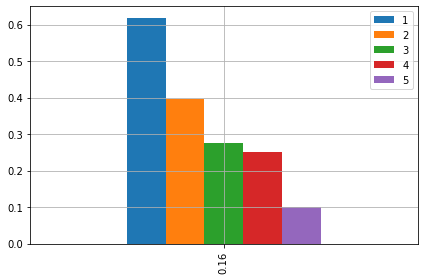

In [194]:
acc_results_df.plot(kind='bar',grid=True)
plt.tight_layout()
plt.show()

In [195]:
acc_results_df.to_csv(os.path.join('results',f'accuracy_10d_2017_2022_{source}.csv'))

Top-acc@k results

In [196]:
top_acc_results_df=pd.DataFrame(top_acc_results).T
top_acc_results_df = top_acc_results_df.fillna(0)
top_acc_results_df.head()

,1-1,2-1,2-2
0.16,0.692308,0.75,0.25


In [197]:
target_cols = '1-1 2-1 2-2 3-1 3-2 3-3'.split()
top_acc_results_df[target_cols].plot(kind='bar',grid=True)
plt.tight_layout()
plt.show()

KeyError: "['3-3', '3-2', '3-1'] not in index"

In [ ]:
top_acc_results_df.to_csv(os.path.join('results',f'top_accuracy_10d_2017_2022_{source}.csv'))

Database size results

In [ ]:
database_size_df=pd.DataFrame(database_size_evol).T
database_size_df.head()

In [ ]:
database_size_df.to_csv(os.path.join('results',f'database_size_evol_10d_2017_2022_{source}.csv'))

Time-based accuracy results

In [ ]:
date_acc_size_df=pd.DataFrame(all_dates_acc_results).T
date_acc_size_df.head()

In [ ]:
date_acc_size_df.to_csv(os.path.join('results',f'date_acc_size_evol_10d_2017_2022_{source}.csv'))

Genre-based results

In [ ]:
avg_genres_acc = {}
for t, genres_values in genres_acc_results.items():
    avg_t_val = {}
    
    for g, acc_values in genres_values.items():
        avg_t_val[g] = np.mean(acc_values)
    avg_genres_acc[t]= avg_t_val

In [ ]:
genre_acc_df=pd.DataFrame(avg_genres_acc).T
genre_acc_df

In [ ]:
genre_acc_df.to_csv(os.path.join('results',f'genre_acc_10d_2017_2022_{source}.csv'))

In [ ]:
print("That's all folks!")